In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install albumentations==1.1.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 10.6 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.20
    Uninstalling albumentations-1.4.20:
      Successfully uninstalled albumentations-1.4.20


In [3]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [4]:
import torch
import torchvision
import torch.nn as nn
import cv2
import numpy as np
import os
import glob as glob
import albumentations as A
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import time
import argparse
import seaborn as sns

from torchvision.models.detection.ssd import (
    SSD,
    DefaultBoxGenerator,
    SSDHead
)
from xml.etree import ElementTree as et
from torch.utils.data import Dataset, DataLoader
from google.colab.patches import cv2_imshow
from albumentations.pytorch import ToTensorV2
from tqdm.auto import tqdm
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torch.optim.lr_scheduler import MultiStepLR
from sklearn.metrics import confusion_matrix

In [5]:
BATCH_SIZE = 16 # Increase / decrease according to GPU memeory.
RESIZE_TO = 640 # Resize the image for training and transforms.
NUM_EPOCHS = 75 # Number of epochs to train for.
NUM_WORKERS = 0 # Number of parallel workers for data loading.

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Training images and XML files directory.
TRAIN_DIR = '/content/drive/MyDrive/Skripsi/CobaSkripsi7/data/train'
# Validation images and XML files directory.
VALID_DIR = '/content/drive/MyDrive/Skripsi/CobaSkripsi7/data/valid'

# Classes: 0 index is reserved for background.
CLASSES = [
    '__background__', 'food', 'paper', 'plastic', 'wood'
]

NUM_CLASSES = len(CLASSES)

# Whether to visualize images after crearing the data loaders.
VISUALIZE_TRANSFORMED_IMAGES = False

# Location to save model and plots.
OUT_DIR = '/content/drive/MyDrive/Skripsi/CobaSkripsi7/outputs'

In [6]:
def create_model(num_classes=91, size=300, nms=0.45):
    model_backbone = torchvision.models.resnet34(
        weights=torchvision.models.ResNet34_Weights.DEFAULT
    )
    conv1 = model_backbone.conv1
    bn1 = model_backbone.bn1
    relu = model_backbone.relu
    max_pool = model_backbone.maxpool
    layer1 = model_backbone.layer1
    layer2 = model_backbone.layer2
    layer3 = model_backbone.layer3
    layer4 = model_backbone.layer4
    backbone = nn.Sequential(
        conv1, bn1, relu, max_pool,
        layer1, layer2, layer3, layer4
    )
    out_channels = [512, 512, 512, 512, 512, 512]
    anchor_generator = DefaultBoxGenerator(
        [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
    )
    num_anchors = anchor_generator.num_anchors_per_location()
    head = SSDHead(out_channels, num_anchors, num_classes)
    model = SSD(
        backbone=backbone,
        num_classes=num_classes,
        anchor_generator=anchor_generator,
        size=(size, size),
        head=head,
        nms_thresh=nms
    )
    return model

if __name__ == '__main__':
    model = create_model(2, 300)
    print(model)
    # Total parameters and trainable parameters.
    total_params = sum(p.numel() for p in model.parameters())
    print(f"{total_params:,} total parameters.")
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{total_trainable_params:,} training parameters.")

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 200MB/s]


SSD(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [7]:
# The dataset class.
class CustomDataset(Dataset):
    def __init__(self, dir_path, width, height, classes, transforms=None):
        self.transforms = transforms
        self.dir_path = dir_path
        self.height = height
        self.width = width
        self.classes = classes
        self.image_file_types = ['*.jpg', '*.jpeg', '*.png', '*.ppm', '*.JPG']
        self.all_image_paths = []

        # Get all the image paths in sorted order.
        for file_type in self.image_file_types:
            self.all_image_paths.extend(glob.glob(os.path.join(self.dir_path, file_type)))
        self.all_images = [image_path.split(os.path.sep)[-1] for image_path in self.all_image_paths]
        self.all_images = sorted(self.all_images)

    def __getitem__(self, idx):
        # Capture the image name and the full image path.
        image_name = self.all_images[idx]
        image_path = os.path.join(self.dir_path, image_name)

        # Read and preprocess the image.
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_resized = cv2.resize(image, (self.width, self.height))
        image_resized /= 255.0

        # Capture the corresponding XML file for getting the annotations.
        annot_filename = os.path.splitext(image_name)[0] + '.xml'
        annot_file_path = os.path.join(self.dir_path, annot_filename)

        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()

        # Original image width and height.
        image_width = image.shape[1]
        image_height = image.shape[0]

        # Box coordinates for xml files are extracted
        # and corrected for image size given.
        for member in root.findall('object'):
            # Get label and map the `classes`.
            labels.append(self.classes.index(member.find('name').text))

            # Left corner x-coordinates.
            xmin = int(member.find('bndbox').find('xmin').text)
            # Right corner x-coordinates.
            xmax = int(member.find('bndbox').find('xmax').text)
            # Left corner y-coordinates.
            ymin = int(member.find('bndbox').find('ymin').text)
            # Right corner y-coordinates.
            ymax = int(member.find('bndbox').find('ymax').text)

            # Resize the bounding boxes according
            # to resized image `width`, `height`.
            xmin_final = (xmin/image_width)*self.width
            xmax_final = (xmax/image_width)*self.width
            ymin_final = (ymin/image_height)*self.height
            ymax_final = (ymax/image_height)*self.height

            # Check that all coordinates are within the image.
            if xmax_final > self.width:
                xmax_final = self.width
            if ymax_final > self.height:
                ymax_final = self.height

            boxes.append([xmin_final, ymin_final, xmax_final, ymax_final])

        # Bounding box to tensor.
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Area of the bounding boxes.
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) if len(boxes) > 0 \
            else torch.as_tensor(boxes, dtype=torch.float32)
        # No crowd instances.
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        # Labels to tensor.
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Prepare the final `target` dictionary.
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id

        # Apply the image transforms.
        if self.transforms:
            sample = self.transforms(image = image_resized,
                                     bboxes = target['boxes'],
                                     labels = labels)
            image_resized = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])

        if np.isnan((target['boxes']).numpy()).any() or target['boxes'].shape == torch.Size([0]):
            target['boxes'] = torch.zeros((0, 4), dtype=torch.int64)
        return image_resized, target

    def __len__(self):
        return len(self.all_images)

# Prepare the final datasets and data loaders.
def create_train_dataset(DIR):
    train_dataset = CustomDataset(
        DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_train_transform()
    )
    return train_dataset
def create_valid_dataset(DIR):
    valid_dataset = CustomDataset(
        DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_valid_transform()
    )
    return valid_dataset
def create_train_loader(train_dataset, num_workers=0):
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=num_workers,
        collate_fn=collate_fn,
        drop_last=False
    )
    return train_loader
def create_valid_loader(valid_dataset, num_workers=0):
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_fn,
        drop_last=False
    )
    return valid_loader


# execute `datasets.py`` using Python command from
# Terminal to visualize sample images
# USAGE: python datasets.py
if __name__ == '__main__':
    # sanity check of the Dataset pipeline with sample visualization
    dataset = CustomDataset(
        TRAIN_DIR, RESIZE_TO, RESIZE_TO, CLASSES
    )
    print(f"Number of training images: {len(dataset)}")

    # function to visualize a single sample
    def visualize_sample(image, target):
        for box_num in range(len(target['boxes'])):
            box = target['boxes'][box_num]
            label = CLASSES[target['labels'][box_num]]
            normalized_image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
            # Convert the normalized image to 8-bit format for display
            display_image = normalized_image.astype(np.uint8)
            image = cv2.cvtColor(display_image, cv2.COLOR_RGB2BGR)
            cv2.rectangle(
                image,
                (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),
                (0, 0, 255),
                2
            )
            cv2.putText(
                image,
                label,
                (int(box[0]), int(box[1]-5)),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.7,
                (0, 0, 255),
                2
            )
        cv2_imshow(image)
        # cv2.waitKey(0)

    NUM_SAMPLES_TO_VISUALIZE = 5
    for i in range(NUM_SAMPLES_TO_VISUALIZE):
        image, target = dataset[i]
        visualize_sample(image, target)

Output hidden; open in https://colab.research.google.com to view.

In [8]:
plt.style.use('ggplot')

# This class keeps track of the training and validation loss values
# and helps to get the average for each epoch as well.
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's
    validation mAP @0.5:0.95 IoU higher than the previous highest, then save the
    model state.
    """
    def __init__(
        self, best_valid_map=float(0)
    ):
        self.best_valid_map = best_valid_map

    def __call__(
        self,
        model,
        current_valid_map,
        epoch,
        OUT_DIR,
    ):
        if current_valid_map > self.best_valid_map:
            self.best_valid_map = current_valid_map
            print(f"\nBEST VALIDATION mAP: {self.best_valid_map}")
            print(f"\nSAVING BEST MODEL FOR EPOCH: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                }, f"{OUT_DIR}/best_model_resnet34_sgd_0.0005.pth")

def collate_fn(batch):
    """
    To handle the data loading as different images may have different number
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

# Define the training tranforms.
def get_train_transform():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Blur(blur_limit=3, p=0.1),
        A.MotionBlur(blur_limit=3, p=0.1),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.ToGray(p=0.3),
        A.RandomBrightnessContrast(p=0.3),
        A.ColorJitter(p=0.3),
        A.RandomGamma(p=0.3),
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })

# Define the validation transforms.
def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })


def show_tranformed_image(train_loader):
    """
    This function shows the transformed images from the `train_loader`.
    Helps to check whether the tranformed images along with the corresponding
    labels are correct or not.
    Only runs if `VISUALIZE_TRANSFORMED_IMAGES = True` in config.py.
    """
    if len(train_loader) > 0:
        for i in range(1):
            images, targets = next(iter(train_loader))
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
            labels = targets[i]['labels'].cpu().numpy().astype(np.int32)
            sample = images[i].permute(1, 2, 0).cpu().numpy()
            sample = cv2.cvtColor(sample, cv2.COLOR_RGB2BGR)
            for box_num, box in enumerate(boxes):
                cv2.rectangle(sample,
                            (box[0], box[1]),
                            (box[2], box[3]),
                            (0, 0, 255), 2)
                cv2.putText(sample, CLASSES[labels[box_num]],
                            (box[0], box[1]-10), cv2.FONT_HERSHEY_SIMPLEX,
                            1.0, (0, 0, 255), 2)
            cv2.imshow('Transformed image', sample)
            cv2.waitKey(0)
            cv2.destroyAllWindows()

def save_model(epoch, model, optimizer):
    """
    Function to save the trained model till current epoch, or whenver called
    """
    torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, f'{OUT_DIR}/last_model_resnet34_sgd_0.0005.pth')

def save_loss_plot(
    OUT_DIR,
    train_loss_list,
    x_label='iterations',
    y_label='train loss',
    save_name='train_loss'
):
    """
    Function to save both train loss graph.

    :param OUT_DIR: Path to save the graphs.
    :param train_loss_list: List containing the training loss values.
    """
    figure_1 = plt.figure(figsize=(10, 7), num=1, clear=True)
    train_ax = figure_1.add_subplot()
    train_ax.plot(train_loss_list, color='tab:blue')
    train_ax.set_xlabel(x_label)
    train_ax.set_ylabel(y_label)
    figure_1.savefig(f"{OUT_DIR}/{save_name}_resnet34_sgd_0.0005.png")
    print('SAVING PLOTS COMPLETE...')

def save_mAP(OUT_DIR, map_05, map):
    """
    Saves the mAP@0.5 and mAP@0.5:0.95 per epoch.
    :param OUT_DIR: Path to save the graphs.
    :param map_05: List containing mAP values at 0.5 IoU.
    :param map: List containing mAP values at 0.5:0.95 IoU.
    """
    figure = plt.figure(figsize=(10, 7), num=1, clear=True)
    ax = figure.add_subplot()
    ax.plot(
        map_05, color='tab:orange', linestyle='-',
        label='mAP@0.5'
    )
    ax.plot(
        map, color='tab:red', linestyle='-',
        label='mAP@0.5:0.95'
    )
    ax.set_xlabel('Epochs')
    ax.set_ylabel('mAP')
    ax.legend()
    figure.savefig(f"{OUT_DIR}/map_resnet34_sgd_0.0005.png")

Number of training samples: 560
Number of validation samples: 160

SSD(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64,

  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #1 train loss: 14.209
Epoch #1 mAP@0.50:0.95: 0.11635224521160126
Epoch #1 mAP@0.50: 0.38856470584869385
Took 4.179 minutes for epoch 0

BEST VALIDATION mAP: 0.11635224521160126

SAVING BEST MODEL FOR EPOCH: 1

SAVING PLOTS COMPLETE...

EPOCH 2 of 75
Training


<ipython-input-8-0dba882a6941>:152: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  figure = plt.figure(figsize=(10, 7), num=1, clear=True)


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #2 train loss: 7.353
Epoch #2 mAP@0.50:0.95: 0.11964656412601471
Epoch #2 mAP@0.50: 0.34659385681152344
Took 0.440 minutes for epoch 1

BEST VALIDATION mAP: 0.11964656412601471

SAVING BEST MODEL FOR EPOCH: 2

SAVING PLOTS COMPLETE...

EPOCH 3 of 75
Training


<ipython-input-8-0dba882a6941>:137: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  figure_1 = plt.figure(figsize=(10, 7), num=1, clear=True)


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #3 train loss: 6.669
Epoch #3 mAP@0.50:0.95: 0.14324331283569336
Epoch #3 mAP@0.50: 0.4173443019390106
Took 0.448 minutes for epoch 2

BEST VALIDATION mAP: 0.14324331283569336

SAVING BEST MODEL FOR EPOCH: 3

SAVING PLOTS COMPLETE...

EPOCH 4 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #4 train loss: 6.238
Epoch #4 mAP@0.50:0.95: 0.15155810117721558
Epoch #4 mAP@0.50: 0.432312935590744
Took 0.444 minutes for epoch 3

BEST VALIDATION mAP: 0.15155810117721558

SAVING BEST MODEL FOR EPOCH: 4

SAVING PLOTS COMPLETE...

EPOCH 5 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #5 train loss: 5.989
Epoch #5 mAP@0.50:0.95: 0.18669986724853516
Epoch #5 mAP@0.50: 0.50496506690979
Took 0.455 minutes for epoch 4

BEST VALIDATION mAP: 0.18669986724853516

SAVING BEST MODEL FOR EPOCH: 5

SAVING PLOTS COMPLETE...

EPOCH 6 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #6 train loss: 5.754
Epoch #6 mAP@0.50:0.95: 0.20189206302165985
Epoch #6 mAP@0.50: 0.5325296521186829
Took 0.453 minutes for epoch 5

BEST VALIDATION mAP: 0.20189206302165985

SAVING BEST MODEL FOR EPOCH: 6

SAVING PLOTS COMPLETE...

EPOCH 7 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #7 train loss: 5.582
Epoch #7 mAP@0.50:0.95: 0.22304004430770874
Epoch #7 mAP@0.50: 0.570421576499939
Took 0.448 minutes for epoch 6

BEST VALIDATION mAP: 0.22304004430770874

SAVING BEST MODEL FOR EPOCH: 7

SAVING PLOTS COMPLETE...

EPOCH 8 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #8 train loss: 5.331
Epoch #8 mAP@0.50:0.95: 0.24861720204353333
Epoch #8 mAP@0.50: 0.5955578684806824
Took 0.454 minutes for epoch 7

BEST VALIDATION mAP: 0.24861720204353333

SAVING BEST MODEL FOR EPOCH: 8

SAVING PLOTS COMPLETE...

EPOCH 9 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #9 train loss: 5.090
Epoch #9 mAP@0.50:0.95: 0.25703006982803345
Epoch #9 mAP@0.50: 0.6248222589492798
Took 0.453 minutes for epoch 8

BEST VALIDATION mAP: 0.25703006982803345

SAVING BEST MODEL FOR EPOCH: 9

SAVING PLOTS COMPLETE...

EPOCH 10 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #10 train loss: 4.743
Epoch #10 mAP@0.50:0.95: 0.24973255395889282
Epoch #10 mAP@0.50: 0.5927495360374451
Took 0.457 minutes for epoch 9
SAVING PLOTS COMPLETE...

EPOCH 11 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #11 train loss: 4.479
Epoch #11 mAP@0.50:0.95: 0.2718544602394104
Epoch #11 mAP@0.50: 0.6343178749084473
Took 0.456 minutes for epoch 10

BEST VALIDATION mAP: 0.2718544602394104

SAVING BEST MODEL FOR EPOCH: 11

SAVING PLOTS COMPLETE...

EPOCH 12 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #12 train loss: 4.363
Epoch #12 mAP@0.50:0.95: 0.2825469672679901
Epoch #12 mAP@0.50: 0.624215841293335
Took 0.450 minutes for epoch 11

BEST VALIDATION mAP: 0.2825469672679901

SAVING BEST MODEL FOR EPOCH: 12

SAVING PLOTS COMPLETE...

EPOCH 13 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #13 train loss: 4.244
Epoch #13 mAP@0.50:0.95: 0.25973042845726013
Epoch #13 mAP@0.50: 0.5985246896743774
Took 0.452 minutes for epoch 12
SAVING PLOTS COMPLETE...

EPOCH 14 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #14 train loss: 4.097
Epoch #14 mAP@0.50:0.95: 0.2647981643676758
Epoch #14 mAP@0.50: 0.6094375252723694
Took 0.453 minutes for epoch 13
SAVING PLOTS COMPLETE...

EPOCH 15 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #15 train loss: 3.882
Epoch #15 mAP@0.50:0.95: 0.33947232365608215
Epoch #15 mAP@0.50: 0.6597033739089966
Took 0.459 minutes for epoch 14

BEST VALIDATION mAP: 0.33947232365608215

SAVING BEST MODEL FOR EPOCH: 15

SAVING PLOTS COMPLETE...

EPOCH 16 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #16 train loss: 3.782
Epoch #16 mAP@0.50:0.95: 0.2769326865673065
Epoch #16 mAP@0.50: 0.6072364449501038
Took 0.458 minutes for epoch 15
SAVING PLOTS COMPLETE...

EPOCH 17 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #17 train loss: 3.688
Epoch #17 mAP@0.50:0.95: 0.3588907718658447
Epoch #17 mAP@0.50: 0.6656329035758972
Took 0.451 minutes for epoch 16

BEST VALIDATION mAP: 0.3588907718658447

SAVING BEST MODEL FOR EPOCH: 17

SAVING PLOTS COMPLETE...

EPOCH 18 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #18 train loss: 3.401
Epoch #18 mAP@0.50:0.95: 0.35694292187690735
Epoch #18 mAP@0.50: 0.6731659770011902
Took 0.453 minutes for epoch 17
SAVING PLOTS COMPLETE...

EPOCH 19 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #19 train loss: 3.336
Epoch #19 mAP@0.50:0.95: 0.3432358503341675
Epoch #19 mAP@0.50: 0.6715013384819031
Took 0.451 minutes for epoch 18
SAVING PLOTS COMPLETE...

EPOCH 20 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #20 train loss: 3.302
Epoch #20 mAP@0.50:0.95: 0.3581168055534363
Epoch #20 mAP@0.50: 0.6733313202857971
Took 0.454 minutes for epoch 19
SAVING PLOTS COMPLETE...

EPOCH 21 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #21 train loss: 3.140
Epoch #21 mAP@0.50:0.95: 0.31521615386009216
Epoch #21 mAP@0.50: 0.6577572226524353
Took 0.452 minutes for epoch 20
SAVING PLOTS COMPLETE...

EPOCH 22 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #22 train loss: 2.956
Epoch #22 mAP@0.50:0.95: 0.3415171205997467
Epoch #22 mAP@0.50: 0.6853033304214478
Took 0.449 minutes for epoch 21
SAVING PLOTS COMPLETE...

EPOCH 23 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #23 train loss: 2.789
Epoch #23 mAP@0.50:0.95: 0.35771316289901733
Epoch #23 mAP@0.50: 0.711322009563446
Took 0.445 minutes for epoch 22
SAVING PLOTS COMPLETE...

EPOCH 24 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #24 train loss: 2.605
Epoch #24 mAP@0.50:0.95: 0.39900335669517517
Epoch #24 mAP@0.50: 0.6977428197860718
Took 0.450 minutes for epoch 23

BEST VALIDATION mAP: 0.39900335669517517

SAVING BEST MODEL FOR EPOCH: 24

SAVING PLOTS COMPLETE...

EPOCH 25 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #25 train loss: 2.181
Epoch #25 mAP@0.50:0.95: 0.4184127449989319
Epoch #25 mAP@0.50: 0.7262517809867859
Took 0.445 minutes for epoch 24

BEST VALIDATION mAP: 0.4184127449989319

SAVING BEST MODEL FOR EPOCH: 25

SAVING PLOTS COMPLETE...

EPOCH 26 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #26 train loss: 1.901
Epoch #26 mAP@0.50:0.95: 0.43718475103378296
Epoch #26 mAP@0.50: 0.7715557813644409
Took 0.448 minutes for epoch 25

BEST VALIDATION mAP: 0.43718475103378296

SAVING BEST MODEL FOR EPOCH: 26

SAVING PLOTS COMPLETE...

EPOCH 27 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #27 train loss: 1.567
Epoch #27 mAP@0.50:0.95: 0.43266817927360535
Epoch #27 mAP@0.50: 0.7371408343315125
Took 0.446 minutes for epoch 26
SAVING PLOTS COMPLETE...

EPOCH 28 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #28 train loss: 1.279
Epoch #28 mAP@0.50:0.95: 0.41702941060066223
Epoch #28 mAP@0.50: 0.7576214075088501
Took 0.446 minutes for epoch 27
SAVING PLOTS COMPLETE...

EPOCH 29 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #29 train loss: 1.225
Epoch #29 mAP@0.50:0.95: 0.39600884914398193
Epoch #29 mAP@0.50: 0.7869933247566223
Took 0.450 minutes for epoch 28
SAVING PLOTS COMPLETE...

EPOCH 30 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #30 train loss: 1.083
Epoch #30 mAP@0.50:0.95: 0.3914397656917572
Epoch #30 mAP@0.50: 0.7599497437477112
Took 0.454 minutes for epoch 29
SAVING PLOTS COMPLETE...

EPOCH 31 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #31 train loss: 0.898
Epoch #31 mAP@0.50:0.95: 0.49301958084106445
Epoch #31 mAP@0.50: 0.7789574861526489
Took 0.450 minutes for epoch 30

BEST VALIDATION mAP: 0.49301958084106445

SAVING BEST MODEL FOR EPOCH: 31

SAVING PLOTS COMPLETE...

EPOCH 32 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #32 train loss: 0.882
Epoch #32 mAP@0.50:0.95: 0.4878239035606384
Epoch #32 mAP@0.50: 0.7973378300666809
Took 0.442 minutes for epoch 31
SAVING PLOTS COMPLETE...

EPOCH 33 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #33 train loss: 0.748
Epoch #33 mAP@0.50:0.95: 0.39434027671813965
Epoch #33 mAP@0.50: 0.7480019330978394
Took 0.441 minutes for epoch 32
SAVING PLOTS COMPLETE...

EPOCH 34 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #34 train loss: 0.783
Epoch #34 mAP@0.50:0.95: 0.4539705216884613
Epoch #34 mAP@0.50: 0.7575154900550842
Took 0.438 minutes for epoch 33
SAVING PLOTS COMPLETE...

EPOCH 35 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #35 train loss: 0.723
Epoch #35 mAP@0.50:0.95: 0.4248867332935333
Epoch #35 mAP@0.50: 0.7671727538108826
Took 0.442 minutes for epoch 34
SAVING PLOTS COMPLETE...

EPOCH 36 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #36 train loss: 0.731
Epoch #36 mAP@0.50:0.95: 0.4552974998950958
Epoch #36 mAP@0.50: 0.7345718741416931
Took 0.445 minutes for epoch 35
SAVING PLOTS COMPLETE...

EPOCH 37 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #37 train loss: 0.649
Epoch #37 mAP@0.50:0.95: 0.48855483531951904
Epoch #37 mAP@0.50: 0.7786440849304199
Took 0.445 minutes for epoch 36
SAVING PLOTS COMPLETE...

EPOCH 38 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #38 train loss: 0.617
Epoch #38 mAP@0.50:0.95: 0.47488638758659363
Epoch #38 mAP@0.50: 0.786105751991272
Took 0.448 minutes for epoch 37
SAVING PLOTS COMPLETE...

EPOCH 39 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #39 train loss: 0.525
Epoch #39 mAP@0.50:0.95: 0.4760836958885193
Epoch #39 mAP@0.50: 0.7720718383789062
Took 0.454 minutes for epoch 38
SAVING PLOTS COMPLETE...

EPOCH 40 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #40 train loss: 0.551
Epoch #40 mAP@0.50:0.95: 0.4420825242996216
Epoch #40 mAP@0.50: 0.7721884846687317
Took 0.451 minutes for epoch 39
SAVING PLOTS COMPLETE...

EPOCH 41 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #41 train loss: 0.470
Epoch #41 mAP@0.50:0.95: 0.46253904700279236
Epoch #41 mAP@0.50: 0.7767685651779175
Took 0.444 minutes for epoch 40
SAVING PLOTS COMPLETE...

EPOCH 42 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #42 train loss: 0.441
Epoch #42 mAP@0.50:0.95: 0.4731425344944
Epoch #42 mAP@0.50: 0.7577930688858032
Took 0.448 minutes for epoch 41
SAVING PLOTS COMPLETE...

EPOCH 43 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #43 train loss: 0.434
Epoch #43 mAP@0.50:0.95: 0.45166054368019104
Epoch #43 mAP@0.50: 0.7781326770782471
Took 0.451 minutes for epoch 42
SAVING PLOTS COMPLETE...

EPOCH 44 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #44 train loss: 0.444
Epoch #44 mAP@0.50:0.95: 0.43559810519218445
Epoch #44 mAP@0.50: 0.7461540699005127
Took 0.448 minutes for epoch 43
SAVING PLOTS COMPLETE...

EPOCH 45 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #45 train loss: 0.376
Epoch #45 mAP@0.50:0.95: 0.4716002643108368
Epoch #45 mAP@0.50: 0.7838775515556335
Took 0.451 minutes for epoch 44
SAVING PLOTS COMPLETE...

EPOCH 46 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #46 train loss: 0.328
Epoch #46 mAP@0.50:0.95: 0.4834570288658142
Epoch #46 mAP@0.50: 0.7826139330863953
Took 0.450 minutes for epoch 45
SAVING PLOTS COMPLETE...

EPOCH 47 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #47 train loss: 0.283
Epoch #47 mAP@0.50:0.95: 0.47384756803512573
Epoch #47 mAP@0.50: 0.7814416885375977
Took 0.443 minutes for epoch 46
SAVING PLOTS COMPLETE...

EPOCH 48 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #48 train loss: 0.287
Epoch #48 mAP@0.50:0.95: 0.4792580306529999
Epoch #48 mAP@0.50: 0.7786241173744202
Took 0.449 minutes for epoch 47
SAVING PLOTS COMPLETE...

EPOCH 49 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #49 train loss: 0.253
Epoch #49 mAP@0.50:0.95: 0.4646439254283905
Epoch #49 mAP@0.50: 0.7843977212905884
Took 0.454 minutes for epoch 48
SAVING PLOTS COMPLETE...

EPOCH 50 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #50 train loss: 0.217
Epoch #50 mAP@0.50:0.95: 0.462950736284256
Epoch #50 mAP@0.50: 0.7777990698814392
Took 0.454 minutes for epoch 49
SAVING PLOTS COMPLETE...

EPOCH 51 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #51 train loss: 0.225
Epoch #51 mAP@0.50:0.95: 0.4705181419849396
Epoch #51 mAP@0.50: 0.7794671654701233
Took 0.456 minutes for epoch 50
SAVING PLOTS COMPLETE...

EPOCH 52 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #52 train loss: 0.210
Epoch #52 mAP@0.50:0.95: 0.47199514508247375
Epoch #52 mAP@0.50: 0.7815450429916382
Took 0.451 minutes for epoch 51
SAVING PLOTS COMPLETE...

EPOCH 53 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #53 train loss: 0.219
Epoch #53 mAP@0.50:0.95: 0.4768180847167969
Epoch #53 mAP@0.50: 0.7817564010620117
Took 0.450 minutes for epoch 52
SAVING PLOTS COMPLETE...

EPOCH 54 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #54 train loss: 0.206
Epoch #54 mAP@0.50:0.95: 0.46824124455451965
Epoch #54 mAP@0.50: 0.7741685509681702
Took 0.454 minutes for epoch 53
SAVING PLOTS COMPLETE...

EPOCH 55 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #55 train loss: 0.207
Epoch #55 mAP@0.50:0.95: 0.4743020236492157
Epoch #55 mAP@0.50: 0.7821206450462341
Took 0.448 minutes for epoch 54
SAVING PLOTS COMPLETE...

EPOCH 56 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #56 train loss: 0.184
Epoch #56 mAP@0.50:0.95: 0.4686618745326996
Epoch #56 mAP@0.50: 0.7746620178222656
Took 0.445 minutes for epoch 55
SAVING PLOTS COMPLETE...

EPOCH 57 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #57 train loss: 0.197
Epoch #57 mAP@0.50:0.95: 0.4716412425041199
Epoch #57 mAP@0.50: 0.7757093906402588
Took 0.451 minutes for epoch 56
SAVING PLOTS COMPLETE...

EPOCH 58 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #58 train loss: 0.178
Epoch #58 mAP@0.50:0.95: 0.4690644145011902
Epoch #58 mAP@0.50: 0.7757010459899902
Took 0.442 minutes for epoch 57
SAVING PLOTS COMPLETE...

EPOCH 59 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #59 train loss: 0.199
Epoch #59 mAP@0.50:0.95: 0.4758228659629822
Epoch #59 mAP@0.50: 0.7734604477882385
Took 0.447 minutes for epoch 58
SAVING PLOTS COMPLETE...

EPOCH 60 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #60 train loss: 0.161
Epoch #60 mAP@0.50:0.95: 0.468605101108551
Epoch #60 mAP@0.50: 0.7686351537704468
Took 0.452 minutes for epoch 59
SAVING PLOTS COMPLETE...

EPOCH 61 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #61 train loss: 0.175
Epoch #61 mAP@0.50:0.95: 0.4719846248626709
Epoch #61 mAP@0.50: 0.777568519115448
Took 0.442 minutes for epoch 60
SAVING PLOTS COMPLETE...

EPOCH 62 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #62 train loss: 0.165
Epoch #62 mAP@0.50:0.95: 0.46896883845329285
Epoch #62 mAP@0.50: 0.7811469435691833
Took 0.448 minutes for epoch 61
SAVING PLOTS COMPLETE...

EPOCH 63 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #63 train loss: 0.177
Epoch #63 mAP@0.50:0.95: 0.4767865538597107
Epoch #63 mAP@0.50: 0.7766236662864685
Took 0.453 minutes for epoch 62
SAVING PLOTS COMPLETE...

EPOCH 64 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #64 train loss: 0.186
Epoch #64 mAP@0.50:0.95: 0.47041410207748413
Epoch #64 mAP@0.50: 0.7767382264137268
Took 0.445 minutes for epoch 63
SAVING PLOTS COMPLETE...

EPOCH 65 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #65 train loss: 0.182
Epoch #65 mAP@0.50:0.95: 0.47189807891845703
Epoch #65 mAP@0.50: 0.7760586142539978
Took 0.445 minutes for epoch 64
SAVING PLOTS COMPLETE...

EPOCH 66 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #66 train loss: 0.151
Epoch #66 mAP@0.50:0.95: 0.47810113430023193
Epoch #66 mAP@0.50: 0.7768319249153137
Took 0.441 minutes for epoch 65
SAVING PLOTS COMPLETE...

EPOCH 67 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #67 train loss: 0.165
Epoch #67 mAP@0.50:0.95: 0.474214106798172
Epoch #67 mAP@0.50: 0.7709684371948242
Took 0.453 minutes for epoch 66
SAVING PLOTS COMPLETE...

EPOCH 68 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #68 train loss: 0.163
Epoch #68 mAP@0.50:0.95: 0.4755105972290039
Epoch #68 mAP@0.50: 0.776506245136261
Took 0.448 minutes for epoch 67
SAVING PLOTS COMPLETE...

EPOCH 69 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #69 train loss: 0.165
Epoch #69 mAP@0.50:0.95: 0.47270941734313965
Epoch #69 mAP@0.50: 0.7687603235244751
Took 0.448 minutes for epoch 68
SAVING PLOTS COMPLETE...

EPOCH 70 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #70 train loss: 0.135
Epoch #70 mAP@0.50:0.95: 0.46639981865882874
Epoch #70 mAP@0.50: 0.774064838886261
Took 0.451 minutes for epoch 69
SAVING PLOTS COMPLETE...

EPOCH 71 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #71 train loss: 0.159
Epoch #71 mAP@0.50:0.95: 0.4703359007835388
Epoch #71 mAP@0.50: 0.771298885345459
Took 0.446 minutes for epoch 70
SAVING PLOTS COMPLETE...

EPOCH 72 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #72 train loss: 0.147
Epoch #72 mAP@0.50:0.95: 0.4760851562023163
Epoch #72 mAP@0.50: 0.7749674320220947
Took 0.457 minutes for epoch 71
SAVING PLOTS COMPLETE...

EPOCH 73 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #73 train loss: 0.154
Epoch #73 mAP@0.50:0.95: 0.4701369106769562
Epoch #73 mAP@0.50: 0.7762700915336609
Took 0.448 minutes for epoch 72
SAVING PLOTS COMPLETE...

EPOCH 74 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #74 train loss: 0.156
Epoch #74 mAP@0.50:0.95: 0.4850740134716034
Epoch #74 mAP@0.50: 0.7783575654029846
Took 0.453 minutes for epoch 73
SAVING PLOTS COMPLETE...

EPOCH 75 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #75 train loss: 0.152
Epoch #75 mAP@0.50:0.95: 0.47421231865882874
Epoch #75 mAP@0.50: 0.7745136022567749
Took 0.451 minutes for epoch 74
SAVING PLOTS COMPLETE...


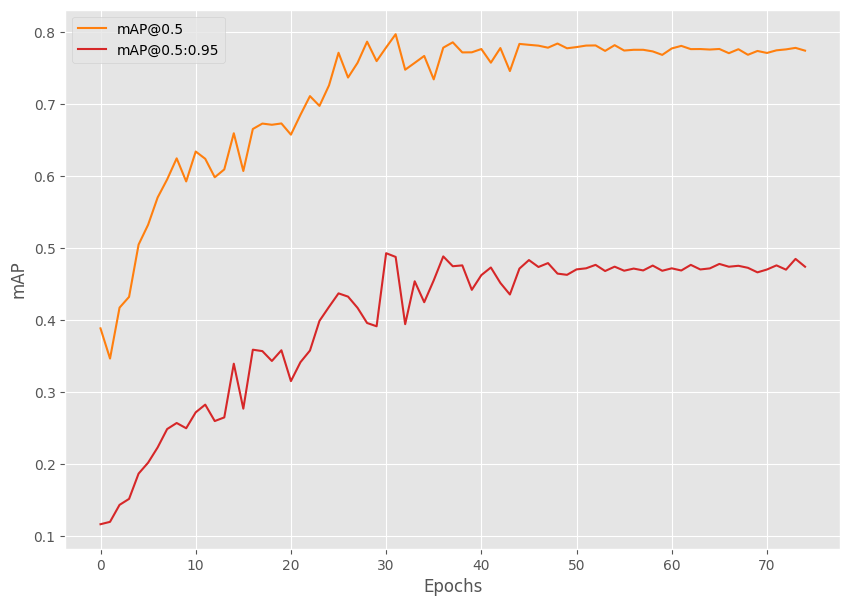

In [ ]:
plt.style.use('ggplot')

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Function for running training iterations.
def train(train_data_loader, model):
    print('Training')
    model.train()

     # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))

    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        train_loss_hist.send(loss_value)

        losses.backward()
        optimizer.step()

        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return loss_value

# Function for running validation iterations.
def validate(valid_data_loader, model):
    print('Validating')
    model.eval()

    # Initialize tqdm progress bar.
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    target = []
    preds = []
    for i, data in enumerate(prog_bar):
        images, targets = data

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            outputs = model(images, targets)

        # For mAP calculation using Torchmetrics.
        #####################################
        for i in range(len(images)):
            true_dict = dict()
            preds_dict = dict()
            true_dict['boxes'] = targets[i]['boxes'].detach().cpu()
            true_dict['labels'] = targets[i]['labels'].detach().cpu()
            preds_dict['boxes'] = outputs[i]['boxes'].detach().cpu()
            preds_dict['scores'] = outputs[i]['scores'].detach().cpu()
            preds_dict['labels'] = outputs[i]['labels'].detach().cpu()
            preds.append(preds_dict)
            target.append(true_dict)
        #####################################

    metric = MeanAveragePrecision()
    metric.update(preds, target)
    metric_summary = metric.compute()
    return metric_summary

if __name__ == '__main__':
    os.makedirs('outputs', exist_ok=True)
    train_dataset = create_train_dataset(TRAIN_DIR)
    valid_dataset = create_valid_dataset(VALID_DIR)
    train_loader = create_train_loader(train_dataset, NUM_WORKERS)
    valid_loader = create_valid_loader(valid_dataset, NUM_WORKERS)
    print(f"Number of training samples: {len(train_dataset)}")
    print(f"Number of validation samples: {len(valid_dataset)}\n")

    # Initialize the model and move to the computation device.
    model = create_model(num_classes=NUM_CLASSES, size=RESIZE_TO)
    model = model.to(DEVICE)
    print(model)
    # Total parameters and trainable parameters.
    total_params = sum(p.numel() for p in model.parameters())
    print(f"{total_params:,} total parameters.")
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{total_trainable_params:,} training parameters.")
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(
        params, lr=0.0005, momentum=0.9, nesterov=True
    )
    scheduler = MultiStepLR(
        optimizer=optimizer, milestones=[45], gamma=0.1, verbose=True
    )

    # To monitor training loss
    train_loss_hist = Averager()
    # To store training loss and mAP values.
    train_loss_list = []
    map_50_list = []
    map_list = []

    # Mame to save the trained model with.
    MODEL_NAME = 'model'

    # Whether to show transformed images from data loader or not.
    if VISUALIZE_TRANSFORMED_IMAGES:
        show_tranformed_image(train_loader)

    # To save best model.
    save_best_model = SaveBestModel()

    # Training loop.
    for epoch in range(NUM_EPOCHS):
        print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")

        # Reset the training loss histories for the current epoch.
        train_loss_hist.reset()

        # Start timer and carry out training and validation.
        start = time.time()
        train_loss = train(train_loader, model)
        metric_summary = validate(valid_loader, model)
        print(f"Epoch #{epoch+1} train loss: {train_loss_hist.value:.3f}")
        print(f"Epoch #{epoch+1} mAP@0.50:0.95: {metric_summary['map']}")
        print(f"Epoch #{epoch+1} mAP@0.50: {metric_summary['map_50']}")
        end = time.time()
        print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")

        train_loss_list.append(train_loss)
        map_50_list.append(metric_summary['map_50'])
        map_list.append(metric_summary['map'])

        # save the best model till now.
        save_best_model(
            model, float(metric_summary['map']), epoch, 'outputs'
        )
        # Save the current epoch model.
        save_model(epoch, model, optimizer)

        # Save loss plot.
        save_loss_plot(OUT_DIR, train_loss_list)

        # Save mAP plot.
        save_mAP(OUT_DIR, map_50_list, map_list)
        scheduler.step()

<ipython-input-10-24a63866a4e0>:109: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/drive/MyDrive/Skripsi/CobaSkripsi7/outputs/best_model_re

Validating


  0%|          | 0/5 [00:00<?, ?it/s]

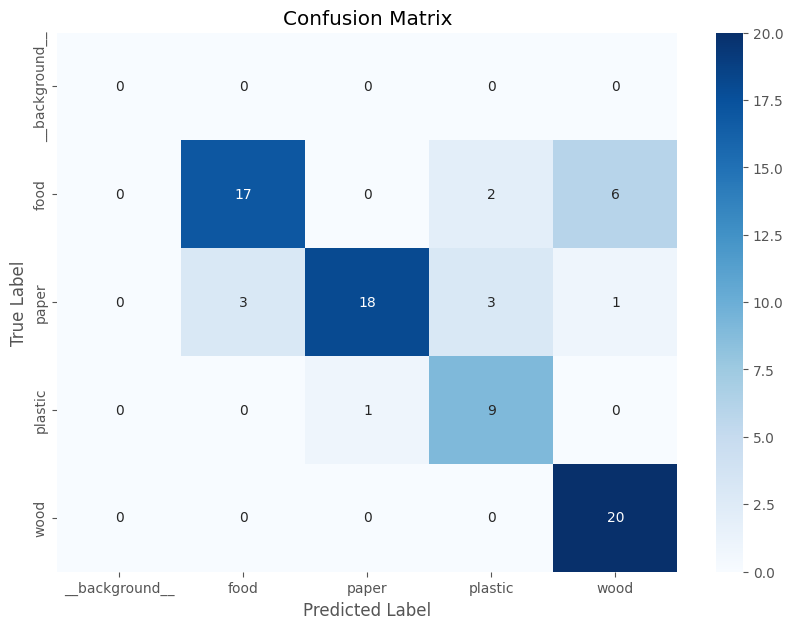

TP: 88, TN: 640, FP: 96, FN: 96
Precision: 47.83
Recall: 47.83
F1 Score: 47.8261
Class 0 - Average Precision (AP): Not available or NaN
Class 1 - Average Precision (AP): Not available or NaN
Class 2 - Average Precision (AP): Not available or NaN
Class 3 - Average Precision (AP): Not available or NaN
mAP_50: 91.022
mAP_50_95: 56.630


In [10]:
# Evaluation function
def validate(valid_data_loader, model):
    print('Validating')
    model.eval()

    # Initialize tqdm progress bar.
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    target = []
    preds = []

    # Initialize TP, TN, FP, FN
    TP = 0
    TN = 0
    FP = 0
    FN = 0

    # Inisialisasi confusion matrix
    conf_matrix = np.zeros((NUM_CLASSES, NUM_CLASSES), dtype=int)

    for i, data in enumerate(prog_bar):
        images, targets = data

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            outputs = model(images, targets)

        # For mAP calculation using Torchmetrics.
        #####################################
        for i in range(len(images)):
            true_dict = dict()
            preds_dict = dict()
            true_dict['boxes'] = targets[i]['boxes'].detach().cpu()
            true_dict['labels'] = targets[i]['labels'].detach().cpu()
            preds_dict['boxes'] = outputs[i]['boxes'].detach().cpu()
            preds_dict['scores'] = outputs[i]['scores'].detach().cpu()
            preds_dict['labels'] = outputs[i]['labels'].detach().cpu()
            preds.append(preds_dict)
            target.append(true_dict)

            true_labels = targets[i]['labels'].detach().cpu().numpy()
            pred_labels = outputs[i]['labels'].detach().cpu().numpy()

            # Check if pred_labels is empty before iterating
            if len(pred_labels) > 0:
                # Update confusion matrix
                for i in range(len(true_labels)):
                    true_class = true_labels[i]
                    pred_class = pred_labels[i]
                    conf_matrix[true_class, pred_class] += 1

                # Hitung TP, TN, FN, FP untuk setiap kelas
                for class_id in range(NUM_CLASSES):
                    TP += np.sum((pred_labels == class_id) & (true_labels == class_id))
                    TN += np.sum((pred_labels != class_id) & (true_labels != class_id))
                    FP += np.sum((pred_labels == class_id) & (true_labels != class_id))
                    FN += np.sum((pred_labels != class_id) & (true_labels == class_id))

        #####################################

    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=CLASSES, yticklabels=CLASSES)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    metric = MeanAveragePrecision(class_metrics=True) # Enable class metrics
    metric.update(preds, target)
    metric_summary = metric.compute()

    # Cetak hasil TP, TN, FN, FP
    print(f"TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")

    # Calculate F1 score
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    print(f"Precision: {precision *100:.2f}")
    print(f"Recall: {recall *100:.2f}")
    print(f"F1 Score: {f1_score *100:.4f}")

    # Check if 'map_per_class' is present and iterable
    if 'map_per_class' in metric_summary and isinstance(metric_summary['map_per_class'], (list, tuple, torch.Tensor)):
        class_names = ['__background__', 'food', 'paper', 'plastic', 'wood']  # Your class names
        for class_idx, ap in enumerate(metric_summary['map_per_class']):
            if not torch.isnan(ap) and ap.dim() > 0: # Check for NaN and 0-d tensors
                print(f"Class {class_idx} - Average Precision (AP): {ap:.4f}")
            else:
                print(f"Class {class_idx} - Average Precision (AP): Not available or NaN")
    else:
        print("Per-class mAP not available in metric_summary")

    # Return TP, TN, FP, FN along with other metrics
    metric_summary['TP'] = TP
    metric_summary['TN'] = TN
    metric_summary['FP'] = FP
    metric_summary['FN'] = FN
    metric_summary['F1'] = f1_score # Add F1 score to the dictionary

    return metric_summary

if __name__ == '__main__':
    # Load the best model and trained weights.
    model = create_model(num_classes=NUM_CLASSES, size=640)
    checkpoint = torch.load('/content/drive/MyDrive/Skripsi/CobaSkripsi7/outputs/best_model_resnet34_sgd_0.0005.pth')
    # checkpoint = torch.load('/content/drive/MyDrive/Skripsi/CobaSkripsi7/outputs/best_model_sgd_resnet101.pth', map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(DEVICE).eval()

    test_dataset = create_valid_dataset(
        '/content/drive/MyDrive/Skripsi/CobaSkripsi7/data/test'
    )
    test_loader = create_valid_loader(test_dataset, num_workers=NUM_WORKERS)

    metric_summary = validate(test_loader, model)
    print(f"mAP_50: {metric_summary['map_50']*100:.3f}")
    print(f"mAP_50_95: {metric_summary['map']*100:.3f}")

In [ ]:
np.random.seed(42)

# Definisikan argumen secara manual untuk Colab
args = {
    'input': '/content/drive/MyDrive/Skripsi/CobaSkripsi7/data/test',  # Path ke folder input
    'imgsz': 640,  # Ukuran gambar yang diinginkan
    'threshold': 0.25  # Threshold deteksi
}

os.makedirs('/content/drive/MyDrive/Skripsi/CobaSkripsi7/inference_outputs/images_resnet34_sgd_0.0005', exist_ok=True)

# Define COLORS and CLASSES
COLORS = [[0, 0, 0], [255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 0]]  # Tambahkan warna sesuai kebutuhan
CLASSES = ['__background__', 'food', 'paper', 'plastic', 'wood']  # Sesuaikan dengan dataset Anda

# Load model terbaik
model = create_model(num_classes=NUM_CLASSES, size=640)
checkpoint = torch.load('/content/drive/MyDrive/Skripsi/CobaSkripsi7/outputs/best_model_resnet34_sgd_0.0005.pth', map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE).eval()

# Path ke folder gambar uji
DIR_TEST = args['input']
test_images = glob.glob(f"{DIR_TEST}/*.jpg")
print(f"Test instances: {len(test_images)}")

frame_count = 0 # To count total frames.
total_fps = 0 # To get the final frames per second.

for i in range(len(test_images)):
    # Get the image file name for saving output later on.
    image_name = test_images[i].split(os.path.sep)[-1].split('.')[0]
    image = cv2.imread(test_images[i])
    orig_image = image.copy()
    if args['imgsz'] is not None:
        image = cv2.resize(image, (args['imgsz'], args['imgsz']))
    print(image.shape)
    # BGR to RGB.
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    # Make the pixel range between 0 and 1.
    image /= 255.0
    # Bring color channels to front (H, W, C) => (C, H, W).
    image_input = np.transpose(image, (2, 0, 1)).astype(np.float32)
    # Convert to tensor.
    image_input = torch.tensor(image_input, dtype=torch.float).cuda()
    # Add batch dimension.
    image_input = torch.unsqueeze(image_input, 0)
    start_time = time.time()
    # Predictions
    with torch.no_grad():
        outputs = model(image_input.to(DEVICE))
    end_time = time.time()

    # Get the current fps.
    fps = 1 / (end_time - start_time)
    # Total FPS till current frame.
    total_fps += fps
    frame_count += 1

    # Load all detection to CPU for further operations.
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
    # Carry further only if there are detected boxes.
    if len(outputs[0]['boxes']) != 0:
        boxes = outputs[0]['boxes'].data.numpy()
        scores = outputs[0]['scores'].data.numpy()
        # Filter out boxes according to `detection_threshold`.
        boxes = boxes[scores >= args['threshold']].astype(np.int32)
        draw_boxes = boxes.copy()
        # Get all the predicited class names.
        pred_classes = [CLASSES[i] for i in outputs[0]['labels'].cpu().numpy()]

        # Draw the bounding boxes and write the class name on top of it.
        for j, box in enumerate(draw_boxes):
            class_name = pred_classes[j]
            color = COLORS[CLASSES.index(class_name)]
            # Recale boxes.
            xmin = int((box[0] / image.shape[1]) * orig_image.shape[1])
            ymin = int((box[1] / image.shape[0]) * orig_image.shape[0])
            xmax = int((box[2] / image.shape[1]) * orig_image.shape[1])
            ymax = int((box[3] / image.shape[0]) * orig_image.shape[0])
            cv2.rectangle(orig_image,
                        (xmin, ymin),
                        (xmax, ymax),
                        color[::-1],
                        3)
            cv2.putText(orig_image,
                        class_name,
                        (xmin, ymin-5),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.8,
                        color[::-1],
                        2,
                        lineType=cv2.LINE_AA)

        # Menampilkan hasil prediksi
        cv2_imshow(orig_image)
        cv2.imwrite(f"/content/drive/MyDrive/Skripsi/CobaSkripsi7/inference_outputs/images_resnet34_sgd_0.0005/{image_name}.jpg", orig_image)
    print(f"Image {i+1} done...")
    print('-'*50)

print('TEST PREDICTIONS COMPLETE')
# cv2.destroyAllWindows()
# Calculate and print the average FPS.
avg_fps = total_fps / frame_count
print(f"Average FPS: {avg_fps:.3f}")

Output hidden; open in https://colab.research.google.com to view.